# AlexNet CIFAR10

1. Training:
Base: Epoch [100/100] Train Loss: 0.0540, Train Acc: 98.16% Test/Val Loss: 0.9505, Test/Val Acc: 80.60%
Data Aug: Epoch [100/100] Train Loss: 0.5700, Train Acc: 80.40% Test/Val Loss: 0.4734, Test/Val Acc: 84.04%
Dropout: Epoch [100/100] Train Loss: 0.7506, Train Acc: 74.75% Test/Val Loss: 0.5055, Test/Val Acc: 83.22%
Batchnorm: Epoch [100/100] Train Loss: 0.4612, Train Acc: 84.17% Test/Val Loss: 0.3940, Test/Val Acc: 86.89%

2. Pruning:
10%: Epoch [10/10] Train Loss: 0.4580, Train Acc: 84.25% Test/Val Loss: 0.3600, Test/Val Acc: 88.03%
30%: Epoch [10/10] Train Loss: 0.4625, Train Acc: 83.88% Test/Val Loss: 0.3655, Test/Val Acc: 87.72%
50%: Epoch [10/10] Train Loss: 0.4562, Train Acc: 84.22% Test/Val Loss: 0.3443, Test/Val Acc: 88.17%
70%: Epoch [10/10] Train Loss: 0.4284, Train Acc: 85.08% Test/Val Loss: 0.3489, Test/Val Acc: 88.39%

3. Quantization:


In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.ao.quantization import QuantStub, DeQuantStub
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
from collections import OrderedDict
import torch.quantization as tq

import helper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


In [ ]:
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            # nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    if isinstance(m, nn.Conv2d) and m.out_channels in [192, 384, 256]:  # layers with bias=1
                        nn.init.constant_(m.bias, 1)
                    else:
                        nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x
    
    def load_model(self, path='alexnet_cifar10.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='alexnet_cifar10.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")
    
    # def forward(self, x):
    #     x = self.quant(x)
    #     x = self.features(x)
    #     x = torch.flatten(x, 1)
    #     x = self.classifier(x)
    #     x = self.dequant(x)
    #     return x

    

In [3]:
train_loader, test_loader = helper.load_dataset()

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


In [ ]:
# model_fp32 = AlexNetCIFAR10()
# # model_fp32.load_model()

# total_params = sum(p.numel() for p in model_fp32.parameters())
# print(f"Total parameters: {total_params}")

# trainable_params = sum(p.numel() for p in model_fp32.parameters() if p.requires_grad)
# print(f"Trainable parameters: {trainable_params}")

Total parameters: 1048330
Trainable parameters: 1048330


In [ ]:
# fp32_metrics = helper.train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,device=device,epochs=100)

Epoch [1/100] 

Train Loss: 1.8526, Train Acc: 29.69% 

Test/Val Loss: 1.5809, Test/Val Acc: 41.64%
Epoch [2/100] 

Train Loss: 1.5271, Train Acc: 43.96% 

Test/Val Loss: 1.2568, Test/Val Acc: 54.86%
Epoch [3/100] 

Train Loss: 1.3151, Train Acc: 52.60% 

Test/Val Loss: 1.1452, Test/Val Acc: 58.60%
Epoch [4/100] 

Train Loss: 1.1853, Train Acc: 57.77% 

Test/Val Loss: 0.9415, Test/Val Acc: 66.73%
Epoch [5/100] 

Train Loss: 1.0915, Train Acc: 61.23% 

Test/Val Loss: 0.8443, Test/Val Acc: 69.77%
Epoch [6/100] 

Train Loss: 1.0167, Train Acc: 64.43% 

Test/Val Loss: 0.7529, Test/Val Acc: 73.90%
Epoch [7/100] 

Train Loss: 0.9665, Train Acc: 66.07% 

Test/Val Loss: 0.7385, Test/Val Acc: 74.73%
Epoch [8/100] 

Train Loss: 0.9052, Train Acc: 68.30% 

Test/Val Loss: 0.7373, Test/Val Acc: 74.95%
Epoch [9/100] 

Train Loss: 0.8694, Train Acc: 69.61% 

Test/Val Loss: 0.7002, Test/Val Acc: 75.72%
Epoch [10/100] 

Train Loss: 0.8437, Train Acc: 70.83% 

Test/Val Loss: 0.6410, Test/Val Acc: 78.38%
Epoch [11/100] 

Train Loss: 0.8128, Train Acc: 71.61% 

Test/Val Loss: 0.6241, Test/Val Acc: 78.88%
Epoch [12/100] 

Train Loss: 0.7896, Train Acc: 72.54% 

Test/Val Loss: 0.5799, Test/Val Acc: 80.12%
Epoch [13/100] 

Train Loss: 0.7701, Train Acc: 73.25% 

Test/Val Loss: 0.6631, Test/Val Acc: 77.56%
Epoch [14/100] 

Train Loss: 0.7452, Train Acc: 74.28% 

Test/Val Loss: 0.6401, Test/Val Acc: 78.70%
Epoch [15/100] 

Train Loss: 0.7314, Train Acc: 74.74% 

Test/Val Loss: 0.7193, Test/Val Acc: 75.06%
Epoch [16/100] 

Train Loss: 0.7186, Train Acc: 74.93% 

Test/Val Loss: 0.5482, Test/Val Acc: 80.96%
Epoch [17/100] 

Train Loss: 0.7102, Train Acc: 75.43% 

Test/Val Loss: 0.4980, Test/Val Acc: 82.92%
Epoch [18/100] 

Train Loss: 0.6878, Train Acc: 76.03% 

Test/Val Loss: 0.5391, Test/Val Acc: 81.67%
Epoch [19/100] 

Train Loss: 0.6774, Train Acc: 76.41% 

Test/Val Loss: 0.5417, Test/Val Acc: 81.44%
Epoch [20/100] 

Train Loss: 0.6650, Train Acc: 76.79% 

Test/Val Loss: 0.5016, Test/Val Acc: 82.89%
Epoch [21/100] 

Train Loss: 0.6591, Train Acc: 77.21% 

Test/Val Loss: 0.5475, Test/Val Acc: 80.91%
Epoch [22/100] 

Train Loss: 0.6464, Train Acc: 77.66% 

Test/Val Loss: 0.4567, Test/Val Acc: 84.51%
Epoch [23/100] 

Train Loss: 0.6366, Train Acc: 77.92% 

Test/Val Loss: 0.4953, Test/Val Acc: 82.87%
Epoch [24/100] 

Train Loss: 0.6383, Train Acc: 77.91% 

Test/Val Loss: 0.4591, Test/Val Acc: 83.98%
Epoch [25/100] 

Train Loss: 0.6243, Train Acc: 78.49% 

Test/Val Loss: 0.4502, Test/Val Acc: 84.81%
Epoch [26/100] 

Train Loss: 0.6213, Train Acc: 78.29% 

Test/Val Loss: 0.4552, Test/Val Acc: 84.62%
Epoch [27/100] 

Train Loss: 0.6109, Train Acc: 78.75% 

Test/Val Loss: 0.4721, Test/Val Acc: 84.06%
Epoch [28/100] 

Train Loss: 0.6040, Train Acc: 78.98% 

Test/Val Loss: 0.4959, Test/Val Acc: 83.60%
Epoch [29/100] 

Train Loss: 0.6007, Train Acc: 79.19% 

Test/Val Loss: 0.4470, Test/Val Acc: 84.96%
Epoch [30/100] 

Train Loss: 0.5966, Train Acc: 79.29% 

Test/Val Loss: 0.4553, Test/Val Acc: 84.69%
Epoch [31/100] 

Train Loss: 0.5909, Train Acc: 79.55% 

Test/Val Loss: 0.4196, Test/Val Acc: 85.43%
Epoch [32/100] 

Train Loss: 0.5853, Train Acc: 79.87% 

Test/Val Loss: 0.4568, Test/Val Acc: 84.63%
Epoch [33/100] 

Train Loss: 0.5809, Train Acc: 79.94% 

Test/Val Loss: 0.4808, Test/Val Acc: 83.52%
Epoch [34/100] 

Train Loss: 0.5794, Train Acc: 79.75% 

Test/Val Loss: 0.4291, Test/Val Acc: 85.59%
Epoch [35/100] 

Train Loss: 0.5726, Train Acc: 80.27% 

Test/Val Loss: 0.4201, Test/Val Acc: 85.40%
Epoch [36/100] 

Train Loss: 0.5713, Train Acc: 80.28% 

Test/Val Loss: 0.4098, Test/Val Acc: 85.83%
Epoch [37/100] 

Train Loss: 0.5651, Train Acc: 80.46% 

Test/Val Loss: 0.4334, Test/Val Acc: 85.15%
Epoch [38/100] 

Train Loss: 0.5606, Train Acc: 80.55% 

Test/Val Loss: 0.4401, Test/Val Acc: 85.01%
Epoch [39/100] 

Train Loss: 0.5565, Train Acc: 80.79% 

Test/Val Loss: 0.4382, Test/Val Acc: 85.34%
Epoch [40/100] 

Train Loss: 0.5523, Train Acc: 80.90% 

Test/Val Loss: 0.4007, Test/Val Acc: 86.45%
Epoch [41/100] 

Train Loss: 0.5520, Train Acc: 80.84% 

Test/Val Loss: 0.4036, Test/Val Acc: 85.96%
Epoch [42/100] 

Train Loss: 0.5537, Train Acc: 80.80% 

Test/Val Loss: 0.3715, Test/Val Acc: 87.14%
Epoch [43/100] 

Train Loss: 0.5536, Train Acc: 80.77% 

Test/Val Loss: 0.4140, Test/Val Acc: 86.15%
Epoch [44/100] 

Train Loss: 0.5380, Train Acc: 81.47% 

Test/Val Loss: 0.3842, Test/Val Acc: 86.94%
Epoch [45/100] 

Train Loss: 0.5366, Train Acc: 81.48% 

Test/Val Loss: 0.3899, Test/Val Acc: 86.65%
Epoch [46/100] 

Train Loss: 0.5404, Train Acc: 81.15% 

Test/Val Loss: 0.3790, Test/Val Acc: 86.85%
Epoch [47/100] 

Train Loss: 0.5280, Train Acc: 81.69% 

Test/Val Loss: 0.3994, Test/Val Acc: 86.49%
Epoch [48/100] 

Train Loss: 0.5326, Train Acc: 81.51% 

Test/Val Loss: 0.3918, Test/Val Acc: 86.33%
Epoch [49/100] 

Train Loss: 0.5289, Train Acc: 81.72% 

Test/Val Loss: 0.4037, Test/Val Acc: 86.27%
Epoch [50/100] 

Train Loss: 0.5229, Train Acc: 81.73% 

Test/Val Loss: 0.4246, Test/Val Acc: 85.31%
Epoch [51/100] 

Train Loss: 0.5263, Train Acc: 81.64% 

Test/Val Loss: 0.3934, Test/Val Acc: 86.69%
Epoch [52/100] 

Train Loss: 0.5224, Train Acc: 81.94% 

Test/Val Loss: 0.4197, Test/Val Acc: 86.09%
Epoch [53/100] 

Train Loss: 0.5163, Train Acc: 82.09% 

Test/Val Loss: 0.3866, Test/Val Acc: 86.75%
Epoch [54/100] 

Train Loss: 0.5175, Train Acc: 82.16% 

Test/Val Loss: 0.4745, Test/Val Acc: 84.31%
Epoch [55/100] 

Train Loss: 0.5132, Train Acc: 82.10% 

Test/Val Loss: 0.3883, Test/Val Acc: 86.13%
Epoch [56/100] 

Train Loss: 0.5178, Train Acc: 81.94% 

Test/Val Loss: 0.4111, Test/Val Acc: 85.66%
Epoch [57/100] 

Train Loss: 0.5144, Train Acc: 82.13% 

Test/Val Loss: 0.3925, Test/Val Acc: 86.86%
Epoch [58/100] 

Train Loss: 0.5110, Train Acc: 82.28% 

Test/Val Loss: 0.3815, Test/Val Acc: 86.95%
Epoch [59/100] 

Train Loss: 0.5054, Train Acc: 82.53% 

Test/Val Loss: 0.4423, Test/Val Acc: 85.10%
Epoch [60/100] 

Train Loss: 0.5077, Train Acc: 82.50% 

Test/Val Loss: 0.3978, Test/Val Acc: 86.63%
Epoch [61/100] 

Train Loss: 0.4968, Train Acc: 82.77% 

Test/Val Loss: 0.3875, Test/Val Acc: 86.99%
Epoch [62/100] 

Train Loss: 0.5087, Train Acc: 82.27% 

Test/Val Loss: 0.4398, Test/Val Acc: 85.31%
Epoch [63/100] 

Train Loss: 0.5058, Train Acc: 82.45% 

Test/Val Loss: 0.3958, Test/Val Acc: 86.45%
Epoch [64/100] 

Train Loss: 0.4996, Train Acc: 82.66% 

Test/Val Loss: 0.4263, Test/Val Acc: 85.84%
Epoch [65/100] 

Train Loss: 0.4985, Train Acc: 82.76% 

Test/Val Loss: 0.3939, Test/Val Acc: 86.85%
Epoch [66/100] 

Train Loss: 0.5014, Train Acc: 82.56% 

Test/Val Loss: 0.3874, Test/Val Acc: 86.49%
Epoch [67/100] 

Train Loss: 0.4965, Train Acc: 82.81% 

Test/Val Loss: 0.3843, Test/Val Acc: 86.94%
Epoch [68/100] 

Train Loss: 0.5024, Train Acc: 82.69% 

Test/Val Loss: 0.3941, Test/Val Acc: 86.61%
Epoch [69/100] 

Train Loss: 0.4994, Train Acc: 82.66% 

Test/Val Loss: 0.3942, Test/Val Acc: 86.89%
Epoch [70/100] 

Train Loss: 0.4843, Train Acc: 83.29% 

Test/Val Loss: 0.3830, Test/Val Acc: 87.37%
Epoch [71/100] 

Train Loss: 0.4964, Train Acc: 82.86% 

Test/Val Loss: 0.3778, Test/Val Acc: 87.57%
Epoch [72/100] 

Train Loss: 0.4911, Train Acc: 83.05% 

Test/Val Loss: 0.3798, Test/Val Acc: 87.30%
Epoch [73/100] 

Train Loss: 0.4913, Train Acc: 83.00% 

Test/Val Loss: 0.3627, Test/Val Acc: 87.58%
Epoch [74/100] 

Train Loss: 0.4878, Train Acc: 83.22% 

Test/Val Loss: 0.3572, Test/Val Acc: 88.02%
Epoch [75/100] 

Train Loss: 0.4866, Train Acc: 83.01% 

Test/Val Loss: 0.4093, Test/Val Acc: 85.98%
Epoch [76/100] 

Train Loss: 0.4875, Train Acc: 83.15% 

Test/Val Loss: 0.3652, Test/Val Acc: 87.80%
Epoch [77/100] 

Train Loss: 0.4814, Train Acc: 83.11% 

Test/Val Loss: 0.4029, Test/Val Acc: 86.53%
Epoch [78/100] 

Train Loss: 0.4816, Train Acc: 83.26% 

Test/Val Loss: 0.3804, Test/Val Acc: 87.19%
Epoch [79/100] 

Train Loss: 0.4833, Train Acc: 83.30% 

Test/Val Loss: 0.3805, Test/Val Acc: 86.87%
Epoch [80/100] 

Train Loss: 0.4881, Train Acc: 83.13% 

Test/Val Loss: 0.3668, Test/Val Acc: 87.37%
Epoch [81/100] 

Train Loss: 0.4765, Train Acc: 83.42% 

Test/Val Loss: 0.4073, Test/Val Acc: 86.44%
Epoch [82/100] 

Train Loss: 0.4831, Train Acc: 83.20% 

Test/Val Loss: 0.3815, Test/Val Acc: 87.16%
Epoch [83/100] 

Train Loss: 0.4779, Train Acc: 83.36% 

Test/Val Loss: 0.3589, Test/Val Acc: 88.02%
Epoch [84/100] 

Train Loss: 0.4790, Train Acc: 83.45% 

Test/Val Loss: 0.3966, Test/Val Acc: 87.26%
Epoch [85/100] 

Train Loss: 0.4850, Train Acc: 83.14% 

Test/Val Loss: 0.3819, Test/Val Acc: 86.85%
Epoch [86/100] 

Train Loss: 0.4792, Train Acc: 83.31% 

Test/Val Loss: 0.3652, Test/Val Acc: 87.94%
Epoch [87/100] 

Train Loss: 0.4746, Train Acc: 83.60% 

Test/Val Loss: 0.3832, Test/Val Acc: 87.49%
Epoch [88/100] 

Train Loss: 0.4734, Train Acc: 83.50% 

Test/Val Loss: 0.3813, Test/Val Acc: 87.33%
Epoch [89/100] 

Train Loss: 0.4730, Train Acc: 83.60% 

Test/Val Loss: 0.3717, Test/Val Acc: 87.36%
Epoch [90/100] 

Train Loss: 0.4649, Train Acc: 83.96% 

Test/Val Loss: 0.3850, Test/Val Acc: 87.03%
Epoch [91/100] 

Train Loss: 0.4770, Train Acc: 83.37% 

Test/Val Loss: 0.3880, Test/Val Acc: 86.80%
Epoch [92/100] 

Train Loss: 0.4699, Train Acc: 83.60% 

Test/Val Loss: 0.4219, Test/Val Acc: 85.84%
Epoch [93/100] 

Train Loss: 0.4685, Train Acc: 83.91% 

Test/Val Loss: 0.4047, Test/Val Acc: 86.76%
Epoch [94/100] 

Train Loss: 0.4726, Train Acc: 83.65% 

Test/Val Loss: 0.3555, Test/Val Acc: 87.94%
Epoch [95/100] 

Train Loss: 0.4710, Train Acc: 83.73% 

Test/Val Loss: 0.4501, Test/Val Acc: 85.29%
Epoch [96/100] 

Train Loss: 0.4718, Train Acc: 83.76% 

Test/Val Loss: 0.4322, Test/Val Acc: 85.64%
Epoch [97/100] 

Train Loss: 0.4706, Train Acc: 83.69% 

Test/Val Loss: 0.3618, Test/Val Acc: 87.86%
Epoch [98/100] 

Train Loss: 0.4655, Train Acc: 83.80% 

Test/Val Loss: 0.3717, Test/Val Acc: 87.34%
Epoch [99/100] 

Train Loss: 0.4637, Train Acc: 84.06% 

Test/Val Loss: 0.3486, Test/Val Acc: 88.34%
Epoch [100/100] 

Train Loss: 0.4612, Train Acc: 84.17% 

Test/Val Loss: 0.3940, Test/Val Acc: 86.89%


In [ ]:
# model_fp32.save_model()

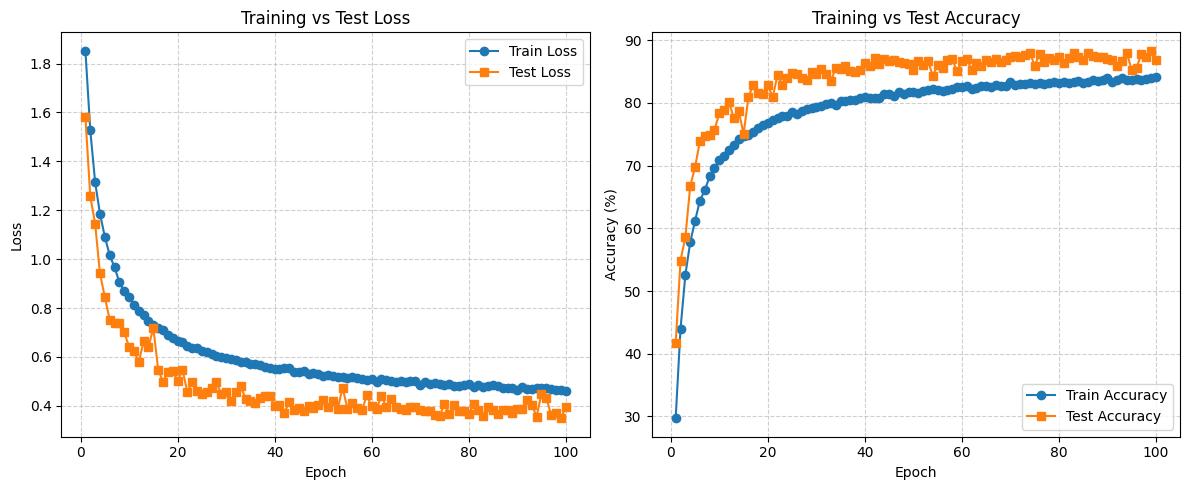

In [ ]:
# helper.plot_metrics(fp32_metrics)

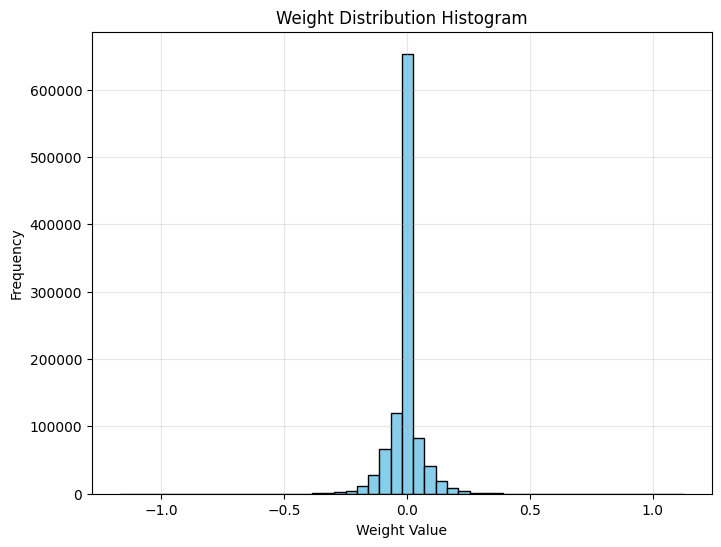

In [ ]:
# helper.plot_weight_histogram(model_fp32)

## Pruning

In [ ]:
# model = AlexNetCIFAR10()
# model.load_model("alexnet_bn_cifar10.pth", device=device)
# model.train()

Model loaded from alexnet_bn_cifar10.pth


AlexNetCIFAR10(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
# import copy
# import torch.nn.utils.prune as prune

# prune_levels = [0.1, 0.3, 0.5, 0.7]
# results = []

# for p in prune_levels:
#     m = copy.deepcopy(model)

#     parameters_to_prune = []
#     for module in m.modules():
#         if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
#             parameters_to_prune.append((module, "weight"))

#     prune.global_unstructured(
#         parameters_to_prune,
#         pruning_method=prune.L1Unstructured,
#         amount=p
#     )

#     # fine-tune
#     metrics = helper.train_model(model=m,train_loader=train_loader,test_loader=test_loader,device=device)

#     # remove pruning masks
#     for module in m.modules():
#         if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
#             prune.remove(module, "weight")

#     percent = p * 100
#     m.save_model(f"alexnet_{percent}.pth")

#     results.append((p, metrics))

Epoch [1/10] 

Train Loss: 0.4703, Train Acc: 83.52% 

Test/Val Loss: 0.4525, Test/Val Acc: 85.29%
Epoch [2/10] 

Train Loss: 0.4656, Train Acc: 83.86% 

Test/Val Loss: 0.3667, Test/Val Acc: 87.68%
Epoch [3/10] 

Train Loss: 0.4652, Train Acc: 83.77% 

Test/Val Loss: 0.3835, Test/Val Acc: 87.22%
Epoch [4/10] 

Train Loss: 0.4636, Train Acc: 83.90% 

Test/Val Loss: 0.3641, Test/Val Acc: 87.70%
Epoch [5/10] 

Train Loss: 0.4676, Train Acc: 83.64% 

Test/Val Loss: 0.3825, Test/Val Acc: 87.37%
Epoch [6/10] 

Train Loss: 0.4606, Train Acc: 83.94% 

Test/Val Loss: 0.3974, Test/Val Acc: 87.12%
Epoch [7/10] 

Train Loss: 0.4615, Train Acc: 84.01% 

Test/Val Loss: 0.4037, Test/Val Acc: 86.40%
Epoch [8/10] 

Train Loss: 0.4603, Train Acc: 83.95% 

Test/Val Loss: 0.4278, Test/Val Acc: 85.74%
Epoch [9/10] 

Train Loss: 0.4588, Train Acc: 83.97% 

Test/Val Loss: 0.3707, Test/Val Acc: 87.57%
Epoch [10/10] 

Train Loss: 0.4580, Train Acc: 84.25% 

Test/Val Loss: 0.3600, Test/Val Acc: 88.03%
Model saved to alexnet_10.0.pth
Epoch [1/10] 

Train Loss: 0.4636, Train Acc: 83.86% 

Test/Val Loss: 0.3658, Test/Val Acc: 87.67%
Epoch [2/10] 

Train Loss: 0.4657, Train Acc: 83.81% 

Test/Val Loss: 0.3642, Test/Val Acc: 87.72%
Epoch [3/10] 

Train Loss: 0.4671, Train Acc: 83.85% 

Test/Val Loss: 0.3716, Test/Val Acc: 87.41%
Epoch [4/10] 

Train Loss: 0.4589, Train Acc: 84.16% 

Test/Val Loss: 0.3628, Test/Val Acc: 87.67%
Epoch [5/10] 

Train Loss: 0.4592, Train Acc: 84.13% 

Test/Val Loss: 0.3823, Test/Val Acc: 87.21%
Epoch [6/10] 

Train Loss: 0.4531, Train Acc: 84.33% 

Test/Val Loss: 0.4021, Test/Val Acc: 87.21%
Epoch [7/10] 

Train Loss: 0.4660, Train Acc: 83.77% 

Test/Val Loss: 0.3737, Test/Val Acc: 88.01%
Epoch [8/10] 

Train Loss: 0.4623, Train Acc: 84.10% 

Test/Val Loss: 0.3945, Test/Val Acc: 86.97%
Epoch [9/10] 

Train Loss: 0.4598, Train Acc: 84.05% 

Test/Val Loss: 0.3679, Test/Val Acc: 87.78%
Epoch [10/10] 

Train Loss: 0.4625, Train Acc: 83.88% 

Test/Val Loss: 0.3655, Test/Val Acc: 87.72%
Model saved to alexnet_30.0.pth
Epoch [1/10] 

Train Loss: 0.4652, Train Acc: 83.89% 

Test/Val Loss: 0.3967, Test/Val Acc: 86.76%
Epoch [2/10] 

Train Loss: 0.4560, Train Acc: 84.02% 

Test/Val Loss: 0.3822, Test/Val Acc: 87.37%
Epoch [3/10] 

Train Loss: 0.4653, Train Acc: 83.72% 

Test/Val Loss: 0.3591, Test/Val Acc: 87.67%
Epoch [4/10] 

Train Loss: 0.4634, Train Acc: 83.82% 

Test/Val Loss: 0.3591, Test/Val Acc: 87.85%
Epoch [5/10] 

Train Loss: 0.4601, Train Acc: 83.98% 

Test/Val Loss: 0.3455, Test/Val Acc: 88.03%
Epoch [6/10] 

Train Loss: 0.4604, Train Acc: 84.16% 

Test/Val Loss: 0.3841, Test/Val Acc: 87.11%
Epoch [7/10] 

Train Loss: 0.4554, Train Acc: 84.37% 

Test/Val Loss: 0.3632, Test/Val Acc: 87.84%
Epoch [8/10] 

Train Loss: 0.4558, Train Acc: 84.22% 

Test/Val Loss: 0.3654, Test/Val Acc: 87.92%
Epoch [9/10] 

Train Loss: 0.4584, Train Acc: 84.09% 

Test/Val Loss: 0.3589, Test/Val Acc: 87.97%
Epoch [10/10] 

Train Loss: 0.4562, Train Acc: 84.22% 

Test/Val Loss: 0.3443, Test/Val Acc: 88.17%
Model saved to alexnet_50.0.pth
Epoch [1/10] 

Train Loss: 0.4421, Train Acc: 84.70% 

Test/Val Loss: 0.3630, Test/Val Acc: 88.37%
Epoch [2/10] 

Train Loss: 0.4361, Train Acc: 84.79% 

Test/Val Loss: 0.3476, Test/Val Acc: 88.21%
Epoch [3/10] 

Train Loss: 0.4353, Train Acc: 85.10% 

Test/Val Loss: 0.3437, Test/Val Acc: 88.51%
Epoch [4/10] 

Train Loss: 0.4316, Train Acc: 84.93% 

Test/Val Loss: 0.3546, Test/Val Acc: 88.08%
Epoch [5/10] 

Train Loss: 0.4273, Train Acc: 85.04% 

Test/Val Loss: 0.3557, Test/Val Acc: 88.41%
Epoch [6/10] 

Train Loss: 0.4304, Train Acc: 85.03% 

Test/Val Loss: 0.3624, Test/Val Acc: 88.11%
Epoch [7/10] 

Train Loss: 0.4304, Train Acc: 85.12% 

Test/Val Loss: 0.3491, Test/Val Acc: 88.37%
Epoch [8/10] 

Train Loss: 0.4294, Train Acc: 85.03% 

Test/Val Loss: 0.3533, Test/Val Acc: 88.10%
Epoch [9/10] 

Train Loss: 0.4274, Train Acc: 85.11% 

Test/Val Loss: 0.3785, Test/Val Acc: 87.66%
Epoch [10/10] 

Train Loss: 0.4284, Train Acc: 85.08% 

Test/Val Loss: 0.3489, Test/Val Acc: 88.39%
Model saved to alexnet_70.0.pth


Metrics for pruning with p=0.1


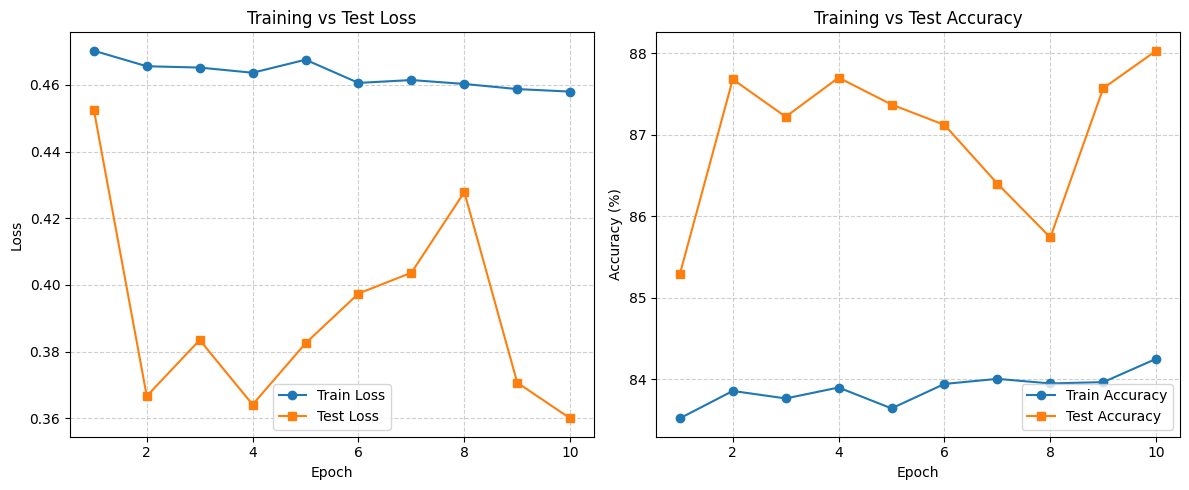

Metrics for pruning with p=0.3


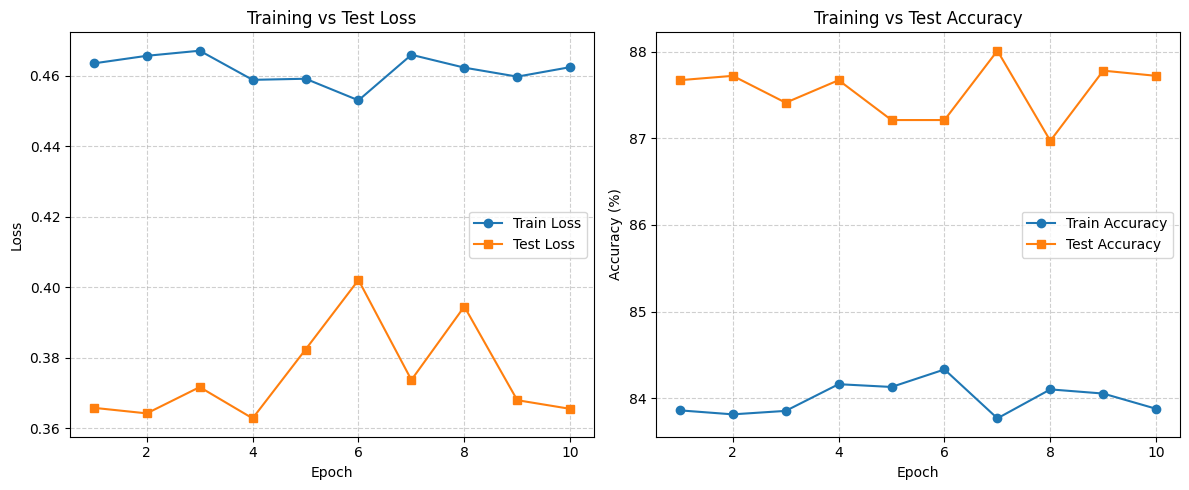

Metrics for pruning with p=0.5


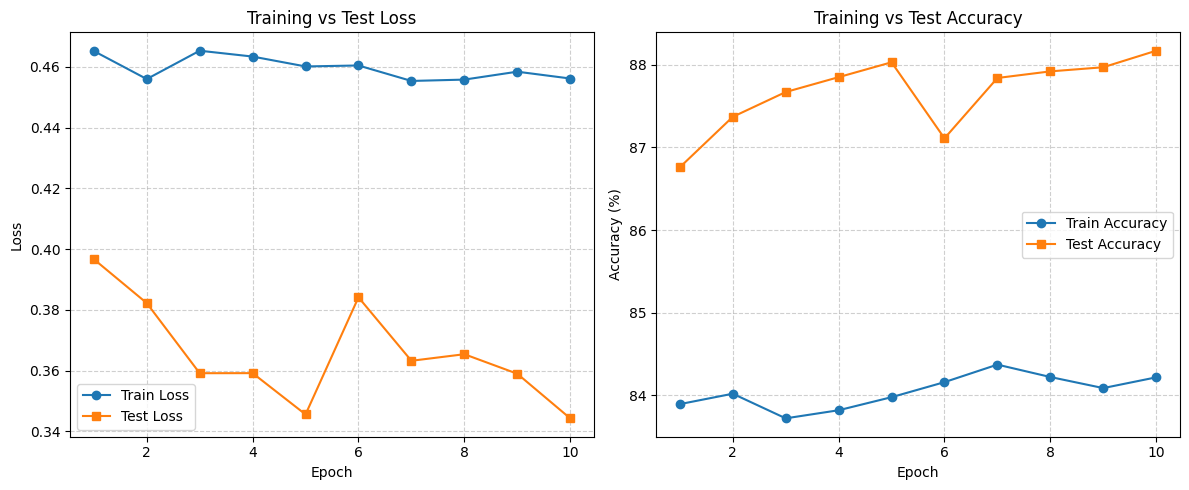

Metrics for pruning with p=0.7


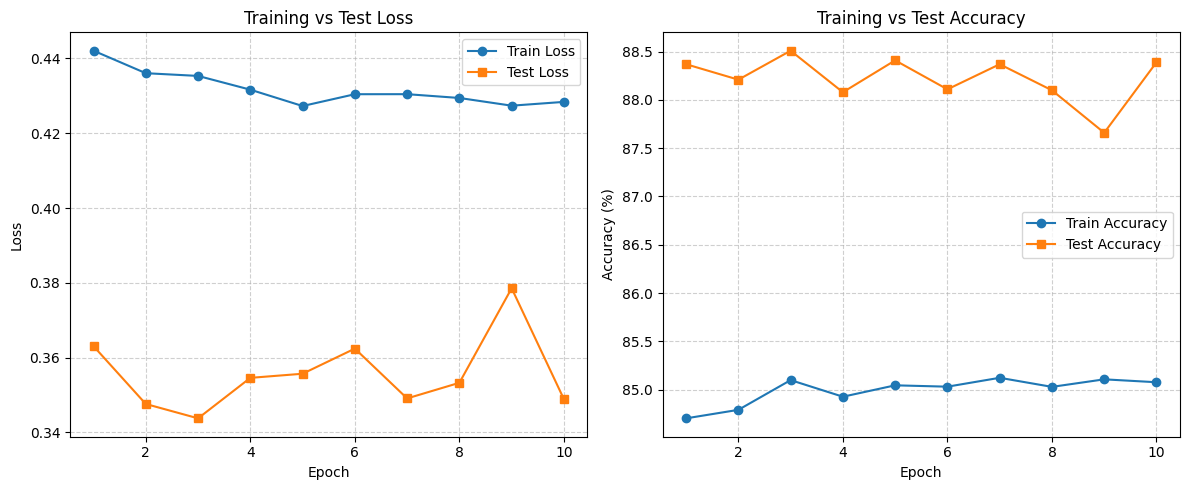

In [ ]:
# for p, metrics in results:
#     print(f"Metrics for pruning with p={p}")
#     helper.plot_metrics(metrics)

## Quantization Aware Training

In [ ]:
import torch
from torch.ao.quantization import get_default_qat_qconfig
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx

model_qat = AlexNetCIFAR10()
model_qat.load_model("alexnet_p70.pth", device='cpu')
model_qat.eval()

# # example input for FX tracing
# example_inputs = (torch.randn(1, 3, 32, 32, device='cpu'),)

# # QAT config dictionary, default 8-bit symmetric QAT
# qconfig_dict = {"": get_default_qat_qconfig('fbgemm')}

# # prepare the model for QAT
# model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)

# model_qat_prepared.to(device)
# model_qat_prepared.train()

model_qat.qconfig = tq.get_default_qat_qconfig("fbgemm")

print(model_qat.qconfig)

# Prepare QAT (adds fake quantizers)
model_qat.train()
tq.prepare_qat(model_qat, inplace=True)


model_qat.to(device)

Model loaded from alexnet_p70.pth
QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


/tmp/SLURM_5196884/ipykernel_4014444/2271678324.py:27: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  tq.prepare_qat(model_qat, inplace=True)
/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprec

AlexNetCIFAR10(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): Conv2d(
      3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      

In [ ]:
qat_metrics = helper.train_model(model=model_qat,train_loader=train_loader,test_loader=test_loader,device=device,epochs=20)

Epoch [1/20] 

Train Loss: 0.4778, Train Acc: 83.46% 

Test/Val Loss: 0.4073, Test/Val Acc: 86.58%
Epoch [2/20] 

Train Loss: 0.4882, Train Acc: 82.95% 

Test/Val Loss: 0.4034, Test/Val Acc: 86.68%
Epoch [3/20] 

Train Loss: 0.4893, Train Acc: 82.97% 

Test/Val Loss: 0.4528, Test/Val Acc: 85.75%
Epoch [4/20] 

Train Loss: 0.4904, Train Acc: 82.95% 

Test/Val Loss: 0.4022, Test/Val Acc: 86.61%
Epoch [5/20] 

Train Loss: 0.4919, Train Acc: 82.81% 

Test/Val Loss: 0.3987, Test/Val Acc: 87.01%
Epoch [6/20] 

Train Loss: 0.4924, Train Acc: 82.90% 

Test/Val Loss: 0.4036, Test/Val Acc: 86.71%
Epoch [7/20] 

Train Loss: 0.4922, Train Acc: 82.89% 

Test/Val Loss: 0.3761, Test/Val Acc: 87.15%
Epoch [8/20] 

Train Loss: 0.4872, Train Acc: 83.01% 

Test/Val Loss: 0.3963, Test/Val Acc: 86.32%
Epoch [9/20] 

Train Loss: 0.4915, Train Acc: 83.02% 

Test/Val Loss: 0.3688, Test/Val Acc: 87.18%
Epoch [10/20] 

Train Loss: 0.5007, Train Acc: 82.69% 

Test/Val Loss: 0.3892, Test/Val Acc: 87.02%
Epoch [11/20] 

Train Loss: 0.4819, Train Acc: 83.19% 

Test/Val Loss: 0.3810, Test/Val Acc: 87.10%
Epoch [12/20] 

Train Loss: 0.4841, Train Acc: 83.24% 

Test/Val Loss: 0.4017, Test/Val Acc: 85.95%
Epoch [13/20] 

Train Loss: 0.4873, Train Acc: 83.20% 

Test/Val Loss: 0.3830, Test/Val Acc: 86.34%
Epoch [14/20] 

Train Loss: 0.4871, Train Acc: 83.21% 

Test/Val Loss: 0.3735, Test/Val Acc: 87.06%
Epoch [15/20] 

Train Loss: 0.4912, Train Acc: 82.94% 

Test/Val Loss: 0.3897, Test/Val Acc: 87.19%
Epoch [16/20] 

Train Loss: 0.4879, Train Acc: 83.02% 

Test/Val Loss: 0.3851, Test/Val Acc: 86.87%
Epoch [17/20] 

Train Loss: 0.4895, Train Acc: 82.92% 

Test/Val Loss: 0.3892, Test/Val Acc: 86.98%
Epoch [18/20] 

Train Loss: 0.4833, Train Acc: 83.13% 

Test/Val Loss: 0.4010, Test/Val Acc: 86.66%
Epoch [19/20] 

Train Loss: 0.4821, Train Acc: 83.17% 

Test/Val Loss: 0.3817, Test/Val Acc: 87.16%
Epoch [20/20] 

Train Loss: 0.4850, Train Acc: 83.18% 

Test/Val Loss: 0.3881, Test/Val Acc: 86.92%


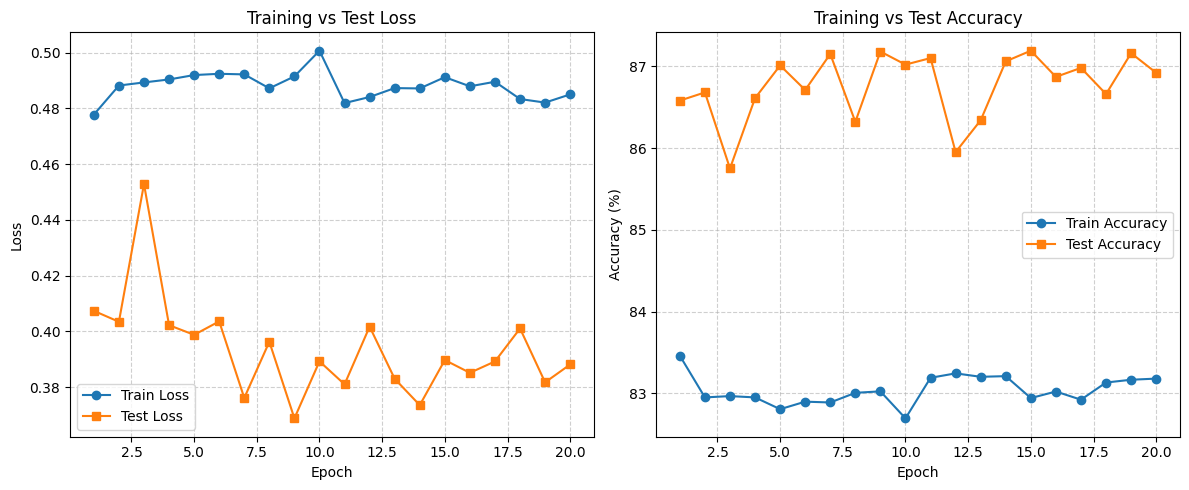

In [ ]:
helper.plot_metrics(qat_metrics)

In [ ]:
# convert to INT8
model_qat.eval()
model_int8 = tq.convert(model_qat.cpu(), inplace=False)
# model_int8 = convert_fx(model_qat_prepared.cpu())
torch.save(model_int8.state_dict(), "alexnet_int8_qat.pth")
# model_int8.load_state_dict(torch.load("squeezenet_int8_qat.pth"))
# model_int8.eval()

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    model.to('cpu')
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    return acc

acc = evaluate(model_int8,test_loader)
print(f"INT8 with QAT Test Accuracy: {acc}%")